In [520]:
from datetime import date
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
pd.options.display.float_format = '{:.3f}'.format

### Define variabels

In [522]:
Income = 400000
IYearGrowth = 0

Expenses = 30000
EYearGrowth = 0

SavingsInitial = 1000000

PropertyPrice = 10000000
PPYearGrowth = 0

Years = 7

DepositRate = 0

Rent = 30000
RYearGrowth = 0

MortgageRate = 0.12
MortgageTermMonths = 60
isEaryRepay = True

### Define structure

In [662]:
def get_structure():
    time_range = pd.date_range(date.today(), periods=Years*12, freq='MS')

    future_income = {y: round(Income*(1+IYearGrowth)**i) for i, y in enumerate(np.unique(time_range.year.values))}
    future_expenses = [round(Expenses*(1+EYearGrowth/12)**i) for i, y in enumerate(time_range)]
    future_house_price = [round(PropertyPrice*(1+PPYearGrowth/12)**i) for i, y in enumerate(time_range)]
    future_rent = {y: round(Rent*(1+RYearGrowth)**i) for i, y in enumerate(np.unique(time_range.year.values))}

    df = pd.DataFrame(index=time_range)
    df['Year'] = df.index.year
    df['Income'] = df['Year'].replace(future_income)
    df['Rent'] = df['Year'].replace(future_rent)
    df['Expenses'] = future_expenses
    df['PropertyPrice'] = future_house_price
    df['Balance'] = 0
    df['Capital'] = 0

    df['Interest'] = 0
    df['Principal'] = 0
    df['StartPropertyDebt'] = 0
    df['EndPropertyDebt'] = 0
    df['MortgagePayment'] = 0
    df['MortgageAdditionalPayment'] = 0
    return df

### Renting, Saving, Buying. RSB

In [678]:
def renting_buying(df):
    # Balance in first month
    df.iloc[0, df.columns.get_loc('Balance')] = \
                SavingsInitial +\
                df.iloc[0, df.columns.get_loc('Income')] -\
                df.iloc[0, df.columns.get_loc('Expenses')] -\
                df.iloc[0, df.columns.get_loc('Rent')]
    df.iloc[0, df.columns.get_loc('Capital')] = df.iloc[0, df.columns.get_loc('Balance')]
    
    # Balance in next months
    for i in range(0, df.shape[0]):
        if i>0:
            df.iloc[i, df.columns.get_loc('Balance')] =\
                df.iloc[i-1, df.columns.get_loc('Balance')]*(1+DepositRate/12) +\
                df.iloc[i, df.columns.get_loc('Income')] -\
                df.iloc[i, df.columns.get_loc('Expenses')] -\
                df.iloc[i, df.columns.get_loc('Rent')]
            
            df.iloc[i, df.columns.get_loc('Capital')] = df.iloc[i, df.columns.get_loc('Balance')]

    # How much months we need to buy the house
    month_to_buy = min([i for i, b in enumerate(list(df['Balance'] -\
                                                     df['PropertyPrice'] > 0)) if b==True])

    # Home purchasing
    df.iloc[month_to_buy, df.columns.get_loc('Balance')] = \
                df.iloc[month_to_buy, df.columns.get_loc('Balance')] - \
                df.iloc[month_to_buy, df.columns.get_loc('PropertyPrice')]
    
    
    
    # Balance in next months after home purchasing
    for i in range(0, df.shape[0]):
        if i>month_to_buy:
            df.iloc[i, df.columns.get_loc('Balance')] =\
                df.iloc[i-1, df.columns.get_loc('Balance')]*(1+DepositRate/12) +\
                df.iloc[i, df.columns.get_loc('Income')] -\
                df.iloc[i, df.columns.get_loc('Expenses')]
            
    df.iloc[i, df.columns.get_loc('Capital')] = df.iloc[i, df.columns.get_loc('Balance')] + df.iloc[i, df.columns.get_loc('PropertyPrice')]
    return df

In [679]:
df = get_structure()
df = renting_buying(df)

### Case 2. Renting

In [682]:
def only_renting(df):
    # Balance in first month
    df.iloc[0, df.columns.get_loc('Balance')] = \
                SavingsInitial +\
                df.iloc[0, df.columns.get_loc('Income')] -\
                df.iloc[0, df.columns.get_loc('Expenses')] -\
                df.iloc[0, df.columns.get_loc('Rent')]
    df.iloc[0, df.columns.get_loc('Capital')] = df.iloc[0, df.columns.get_loc('Balance')]

    # Balance in next months
    for i in range(0, df.shape[0]):
        if i>0:
            df.iloc[i, df.columns.get_loc('Balance')] =\
                df.iloc[i-1, df.columns.get_loc('Balance')]*(1+DepositRate/12) +\
                df.iloc[i, df.columns.get_loc('Income')] -\
                df.iloc[i, df.columns.get_loc('Expenses')] -\
                df.iloc[i, df.columns.get_loc('Rent')]
        df.iloc[i, df.columns.get_loc('Capital')] = df.iloc[i, df.columns.get_loc('Balance')]
    return df

### Case 3. Mortgage, Selling

In [695]:
def initial_mortgage(df):
    # Balance in first month
    df.iloc[0, df.columns.get_loc('Balance')] = \
                SavingsInitial +\
                df.iloc[0, df.columns.get_loc('Income')] -\
                df.iloc[0, df.columns.get_loc('Expenses')]

    # Get the loan
    df.iloc[0, df.columns.get_loc('StartPropertyDebt')] = df.iloc[0, df.columns.get_loc('PropertyPrice')] - SavingsInitial

    # Interest in current debt
    df.iloc[0, df.columns.get_loc('Interest')] =\
        df.iloc[0, df.columns.get_loc('StartPropertyDebt')]*MortgageRate/12

    # Annuity payment
    df.iloc[:, df.columns.get_loc('MortgagePayment')] =\
       df.iloc[0, df.columns.get_loc('StartPropertyDebt')]*\
        (MortgageRate/12 + (MortgageRate/12)/((1+MortgageRate/12)**(MortgageTermMonths)-1))

    # Money for the loan repayment
    df.iloc[0, df.columns.get_loc('Principal')] =\
        df.iloc[0, df.columns.get_loc('MortgagePayment')] - df.iloc[0, df.columns.get_loc('Interest')]

    # Reset the balance
    df.iloc[0, df.columns.get_loc('Balance')] =\
                df.iloc[0, df.columns.get_loc('Income')] -\
                df.iloc[0, df.columns.get_loc('Expenses')] -\
                df.iloc[0, df.columns.get_loc('MortgagePayment')]

    # Assing end property debt
    df.iloc[0, df.columns.get_loc('EndPropertyDebt')] =\
                df.iloc[0, df.columns.get_loc('StartPropertyDebt')] -\
                df.iloc[0, df.columns.get_loc('Principal')]
    
    df.iloc[0, df.columns.get_loc('Capital')] = df.iloc[0, df.columns.get_loc('Balance')] +\
        df.iloc[0, df.columns.get_loc('PropertyPrice')] -\
        df.iloc[0, df.columns.get_loc('EndPropertyDebt')]

    # Balance in next months
    for i in range(0, df.shape[0]):
        if i>0:
            # All expenses
            df.iloc[i, df.columns.get_loc('Balance')] =\
                df.iloc[i, df.columns.get_loc('Income')] -\
                df.iloc[i, df.columns.get_loc('Expenses')] -\
                df.iloc[i, df.columns.get_loc('MortgagePayment')]
        
            # Check wheter we still have the debt
            if df.iloc[i-1, df.columns.get_loc('EndPropertyDebt')] > 1:

                # 1 Assign start property debt
                df.iloc[i, df.columns.get_loc('StartPropertyDebt')] = df.iloc[i-1, df.columns.get_loc('EndPropertyDebt')]

                # 2 Calculate interest in start propert debt
                df.iloc[i, df.columns.get_loc('Interest')] =\
                    df.iloc[i, df.columns.get_loc('StartPropertyDebt')]*MortgageRate/12

                # 3 Calculate principal
                df.iloc[i, df.columns.get_loc('Principal')] =\
                    df.iloc[i, df.columns.get_loc('MortgagePayment')] -\
                    df.iloc[i, df.columns.get_loc('Interest')]

                # 3 Calculate end property debt
                df.iloc[i, df.columns.get_loc('EndPropertyDebt')] =\
                    df.iloc[i, df.columns.get_loc('StartPropertyDebt')] -\
                    df.iloc[i, df.columns.get_loc('Principal')]
                
                df.iloc[i, df.columns.get_loc('Capital')] = df.iloc[i, df.columns.get_loc('Balance')] +\
                    df.iloc[i, df.columns.get_loc('PropertyPrice')] -\
                    df.iloc[i, df.columns.get_loc('EndPropertyDebt')]

            else:
                df.iloc[i, df.columns.get_loc('MortgagePayment')] = 0
                df.iloc[i, df.columns.get_loc('Interest')] = 0
                df.iloc[i, df.columns.get_loc('Principal')] = 0
                df.iloc[i, df.columns.get_loc('StartPropertyDebt')] = 0
                df.iloc[i, df.columns.get_loc('EndPropertyDebt')] = 0

            df.iloc[i, df.columns.get_loc('Balance')] =\
                df.iloc[i-1, df.columns.get_loc('Balance')]*(1+DepositRate/12) +\
                df.iloc[i, df.columns.get_loc('Income')] -\
                df.iloc[i, df.columns.get_loc('Expenses')] -\
                df.iloc[i, df.columns.get_loc('Rent')]
            
            df.iloc[i, df.columns.get_loc('Capital')] = df.iloc[i, df.columns.get_loc('Balance')] +\
                    df.iloc[i, df.columns.get_loc('PropertyPrice')] -\
                    df.iloc[i, df.columns.get_loc('EndPropertyDebt')]
            
    return df

In [696]:
df = get_structure()
df = initial_mortgage(df)

In [697]:
df

,Year,Income,Rent,Expenses,PropertyPrice,Balance,Capital,Interest,Principal,StartPropertyDebt,EndPropertyDebt,MortgagePayment,MortgageAdditionalPayment
2020-02-01,2020,400000,30000,30000,10000000,169799.971,1280000.000,90000.000,110200.029,9000000.000,8889799.971,200200.029,0
2020-03-01,2020,400000,30000,30000,10000000,509799.971,1731302.029,88898.000,111302.029,8889799.971,8778497.941,200200.029,0
2020-04-01,2020,400000,30000,30000,10000000,849799.971,2183717.079,87784.979,112415.050,8778497.941,8666082.892,200200.029,0
2020-05-01,2020,400000,30000,30000,10000000,1189799.971,2637256.279,86660.829,113539.200,8666082.892,8552543.691,200200.029,0
2020-06-01,2020,400000,30000,30000,10000000,1529799.971,3091930.872,85525.437,114674.592,8552543.691,8437869.099,200200.029,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-09-01,2026,400000,30000,30000,10000000,27029799.971,37029799.971,0.000,0.000,0.000,0.000,0.000,0
2026-10-01,2026,400000,30000,30000,10000000,27369799.971,37369799.971,0.000,0.000,0.000,0.000,0.000,0
2026-11-01,2026,400000,30000,30000,10000000,27709799.971,37709799.971,0.000,0.000,0.000,0.000,0.000,0
2026-12-01,2026,400000,30000,30000,10000000,28049799.971,38049799.971,0.000,0.000,0.000,0.000,0.000,0


In [619]:
def cash_result(df):
    return round(df.iloc[df.shape[0]-1, df.columns.get_loc('Balance')] +\
              df.iloc[df.shape[0]-1, df.columns.get_loc('PropertyPrice')])

In [693]:
def get_charts(df):
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    c1 = sns.lineplot(data=df[['Interest', 'Principal', 'MortgagePayment', 'Income', 'Expenses']], dashes=False, ax=ax[0])
    c1.set_title('Period Variables, K')
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in c1.get_yticks()/1000]
    c1.set_yticklabels(ylabels)
    c1.legend(loc='upper right')
    
    c2 = sns.lineplot(data=df[['Balance', 'PropertyPrice', 'Capital', 'EndPropertyDebt']], dashes=False, ax=ax[1])
    c2.set_title('As of date Variables, M')
    ylabels = ['{:,.0f}'.format(x) + 'M' for x in c2.get_yticks()/1000000]
    c2.set_yticklabels(ylabels)
    c2.legend(loc='upper right')

### Case 4. Mortgage with all repayment

In [701]:
def mortgage_repayment(df):
    # Balance in first month
    df.iloc[0, df.columns.get_loc('Balance')] = \
                SavingsInitial +\
                df.iloc[0, df.columns.get_loc('Income')] -\
                df.iloc[0, df.columns.get_loc('Expenses')] -\
                df.iloc[0, df.columns.get_loc('Rent')]

    # Get the loan
    df.iloc[0, df.columns.get_loc('StartPropertyDebt')] = df.iloc[0, df.columns.get_loc('PropertyPrice')] -\
        df.iloc[0, df.columns.get_loc('Balance')]

    # Interest in current debt
    df.iloc[0, df.columns.get_loc('Interest')] =\
        df.iloc[0, df.columns.get_loc('StartPropertyDebt')]*MortgageRate/12

    # Annuity payment
    df.iloc[:, df.columns.get_loc('MortgagePayment')] =\
       df.iloc[0, df.columns.get_loc('StartPropertyDebt')]*\
        (MortgageRate/12 + (MortgageRate/12)/((1+MortgageRate/12)**(MortgageTermMonths)-1))

    df.iloc[0, df.columns.get_loc('MortgageAdditionalPayment')] =\
                df.iloc[0, df.columns.get_loc('Income')] -\
                df.iloc[0, df.columns.get_loc('Expenses')]

    # Money for the loan repayment
    df.iloc[0, df.columns.get_loc('Principal')] =\
        df.iloc[0, df.columns.get_loc('MortgagePayment')] - df.iloc[0, df.columns.get_loc('Interest')]

    # Reset the balance
    df.iloc[0, df.columns.get_loc('Balance')] = 0
    
    # Assing end property debt
    df.iloc[0, df.columns.get_loc('EndPropertyDebt')] =\
                df.iloc[0, df.columns.get_loc('StartPropertyDebt')] -\
                df.iloc[0, df.columns.get_loc('Principal')]
    
    df.iloc[0, df.columns.get_loc('Capital')] = df.iloc[0, df.columns.get_loc('Balance')] +\
                    df.iloc[0, df.columns.get_loc('PropertyPrice')] -\
                    df.iloc[0, df.columns.get_loc('EndPropertyDebt')]



    # Balance in next months
    for i in range(0, df.shape[0]):
        if i>0:
            # Change mortgage payment due to previus end debt
            df.iloc[i, df.columns.get_loc('MortgagePayment')] =\
                df.iloc[i-1, df.columns.get_loc('EndPropertyDebt')]*\
                (MortgageRate/12 + (MortgageRate/12)/((1+MortgageRate/12)**(MortgageTermMonths)-1))

            # All expenses
            df.iloc[i, df.columns.get_loc('Balance')] =\
                df.iloc[i, df.columns.get_loc('Income')] -\
                df.iloc[i, df.columns.get_loc('Expenses')] -\
                df.iloc[i, df.columns.get_loc('MortgagePayment')]


            # Check wheter we still have the debt
            if df.iloc[i-1, df.columns.get_loc('EndPropertyDebt')] > 1:

                # 1 Assign start property debt
                df.iloc[i, df.columns.get_loc('StartPropertyDebt')] = df.iloc[i-1, df.columns.get_loc('EndPropertyDebt')]

                # 2 Calculate interest in start property debt
                df.iloc[i, df.columns.get_loc('Interest')] =\
                    df.iloc[i, df.columns.get_loc('StartPropertyDebt')]*MortgageRate/12

                # 3 Calculate principal
                df.iloc[i, df.columns.get_loc('Principal')] =\
                    df.iloc[i, df.columns.get_loc('MortgagePayment')] -\
                    df.iloc[i, df.columns.get_loc('Interest')]

                # Addition available amount
                df.iloc[i, df.columns.get_loc('MortgageAdditionalPayment')] =\
                    df.iloc[i, df.columns.get_loc('Income')] -\
                    df.iloc[i, df.columns.get_loc('Expenses')]

                # 3 Calculate end property debt
                df.iloc[i, df.columns.get_loc('EndPropertyDebt')] =\
                    df.iloc[i, df.columns.get_loc('StartPropertyDebt')] -\
                    df.iloc[i, df.columns.get_loc('Principal')] -\
                    df.iloc[i, df.columns.get_loc('MortgageAdditionalPayment')]

                # If we overpay
                if df.iloc[i, df.columns.get_loc('EndPropertyDebt')]<0:
                    # Reset
                    df.iloc[i, df.columns.get_loc('EndPropertyDebt')] = 0

                    #
                    df.iloc[i, df.columns.get_loc('MortgageAdditionalPayment')] =\
                        df.iloc[i, df.columns.get_loc('StartPropertyDebt')] -\
                        df.iloc[i, df.columns.get_loc('Principal')]

                # 4 Reset the balace
                df.iloc[i, df.columns.get_loc('Balance')] = 0
                
                df.iloc[i, df.columns.get_loc('Capital')] = df.iloc[i, df.columns.get_loc('Balance')] +\
                    df.iloc[i, df.columns.get_loc('PropertyPrice')] -\
                    df.iloc[i, df.columns.get_loc('EndPropertyDebt')]
            else:
                df.iloc[i, df.columns.get_loc('MortgagePayment')] = 0
                df.iloc[i, df.columns.get_loc('Interest')] = 0
                df.iloc[i, df.columns.get_loc('Principal')] = 0
                df.iloc[i, df.columns.get_loc('StartPropertyDebt')] = 0
                df.iloc[i, df.columns.get_loc('EndPropertyDebt')] = 0
                df.iloc[i, df.columns.get_loc('MortgageAdditionalPayment')] = 0

                df.iloc[i, df.columns.get_loc('Balance')] =\
                df.iloc[i-1, df.columns.get_loc('Balance')]*(1+DepositRate/12) +\
                df.iloc[i, df.columns.get_loc('Income')] -\
                df.iloc[i, df.columns.get_loc('Expenses')] -\
                df.iloc[i, df.columns.get_loc('Rent')]
                
                df.iloc[i, df.columns.get_loc('Capital')] = df.iloc[i, df.columns.get_loc('Balance')] +\
                    df.iloc[i, df.columns.get_loc('PropertyPrice')] -\
                    df.iloc[i, df.columns.get_loc('EndPropertyDebt')]
    return df

# Simulations

In [ ]:
Income = 400000
IYearGrowth = 0

Expenses = 30000
EYearGrowth = 0

SavingsInitial = 1000000

PropertyPrice = 10000000
PPYearGrowth = 0

Years = 7

DepositRate = 0

Rent = 30000
RYearGrowth = 0

MortgageRate = 0.12
MortgageTermMonths = 60
isEaryRepay = True

### 

In [ ]:
only_renting
renting_buying
initial_mortgage
mortgage_repayment

In [665]:
def execute(scenario, detailed=False):
    df = get_structure()
    df = scenario(df)
    if detailed==True:
        get_charts(df)
    print('Capital {0}M'.format(round(cash_result(df)/1000000, 2)))

Capital 39.56M


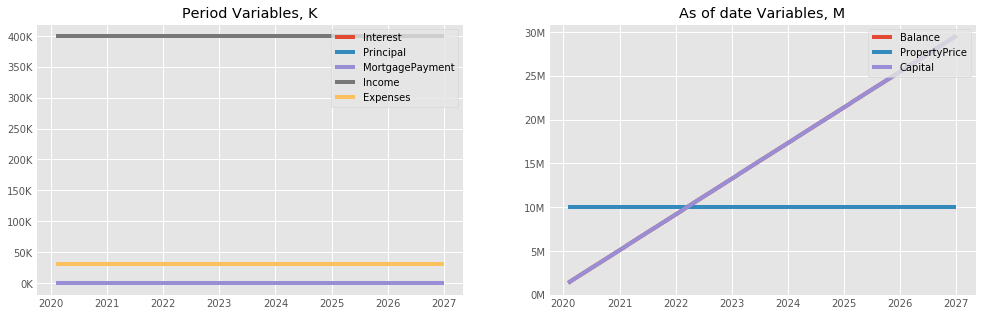

In [685]:
execute(only_renting, detailed=True)

Capital 31.27M


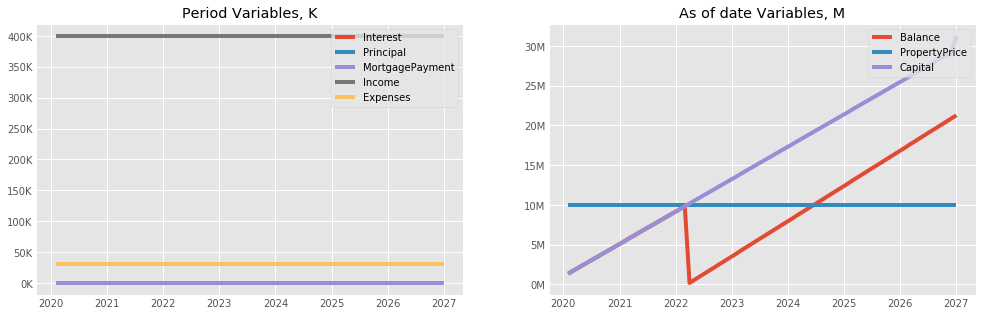

In [686]:
execute(renting_buying, detailed=True)

Capital 31.08M


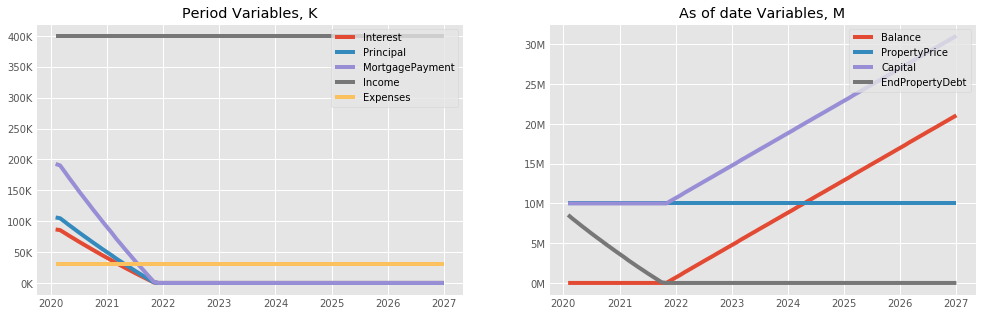

In [694]:
execute(mortgage_repayment, detailed=True)

Capital 38.39M


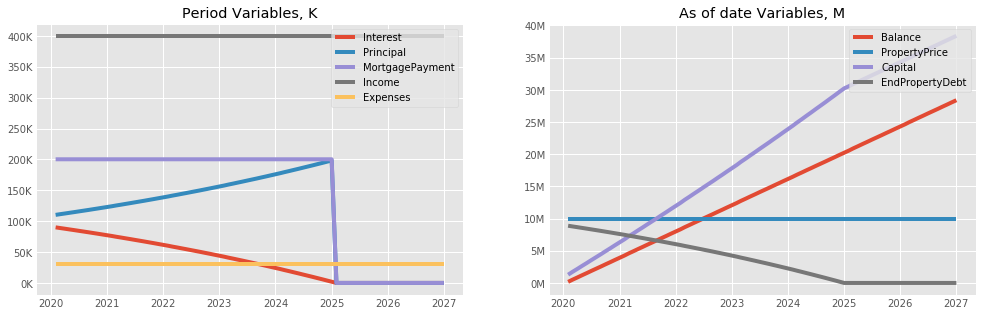

In [698]:
execute(initial_mortgage, detailed=True)